# Visualize the best RFE conformations using cMDS plots

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../..')
from helper_modules.run_or_load import *
from helper_modules.MDS import *

### Load protein related data

In [2]:
prot_name = 'fxa'

In [3]:
DIR = '../1_Download_and_prepare_protein_ensembles'
path_to_file = f'{DIR}/TABLA_MTDATA_FXA_136_crys_LIGS_INFO.json'
df_prot = pd.read_json(path_to_file)
df_prot.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass
1c5m,structural basis for selectivity of a small mo...,2000-12-22,2,D,1.95,-,49.385246,2,"[235, 14]","[[1, 235], [475, 488]]",0,[],None,NaN
1ezq,crystal structure of human coagulation factor ...,2000-09-20,2,A,2.20,-,47.950820,2,"[235, 21]","[[1, 235], [469, 489]]",2,"[CA, RPR]",RPR,428.0
1f0r,crystal structure of human coagulation factor ...,2000-09-20,2,A,2.10,-,47.950820,2,"[235, 21]","[[1, 235], [469, 489]]",2,"[815, CA]",815,434.0


### Load the dimensionality reduction results

In [4]:
df_dims = pd.read_pickle('../3_Protein_Ensembles_Analysis/df_PROTEINS_DIMS_reduced_TABLE.obj')

# Update the df with the mds axis
# Pocket shape
df_prot['vol_x'] = df_dims['mds_vol_pkt_x']
df_prot['vol_y'] = df_dims['mds_vol_pkt_y']
# secondary structure residues RMSD
df_prot['secres_x'] = df_dims['mds_sec_x']
df_prot['secres_y'] = df_dims['mds_sec_y']
# pocket residues RMSD
df_prot['pkt_x'] = df_dims['mds_pkt_x']
df_prot['pkt_y'] = df_dims['mds_pkt_y']

df_prot.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,vol_x,vol_y,secres_x,secres_y,pkt_x,pkt_y
1c5m,structural basis for selectivity of a small mo...,2000-12-22,2,D,1.95,-,49.385246,2,"[235, 14]","[[1, 235], [475, 488]]",0,[],None,NaN,0.113180,-0.057037,-1.907130,2.104030,-0.054454,0.006933
1ezq,crystal structure of human coagulation factor ...,2000-09-20,2,A,2.20,-,47.950820,2,"[235, 21]","[[1, 235], [469, 489]]",2,"[CA, RPR]",RPR,428.0,0.109838,0.123444,-1.340040,1.297487,0.054313,0.042629
1f0r,crystal structure of human coagulation factor ...,2000-09-20,2,A,2.10,-,47.950820,2,"[235, 21]","[[1, 235], [469, 489]]",2,"[815, CA]",815,434.0,0.160114,0.113379,-1.511038,-0.089184,0.033878,0.039221


### Load POVME3 results and single-conformation docking performances (AUC-ROC)

In [5]:
# Extra features to get volume or surface area
df_extra = pd.read_pickle(f'../4_Ensemble_docking_results/TABLE_Confs_Features_and_performances_fxa.pkl')

# Adding to the main df
df_prot['volume'] = df_extra['Pk. Volume']
df_prot['surf_area'] = df_extra['Pk. SASA']

# ROC-AUC single performance
df_prot['AUC-ROC'] = df_extra['AUC-ROC']

df_prot.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,...,Inhib_mass,vol_x,vol_y,secres_x,secres_y,pkt_x,pkt_y,volume,surf_area,AUC-ROC
1c5m,structural basis for selectivity of a small mo...,2000-12-22,2,D,1.95,-,49.385246,2,"[235, 14]","[[1, 235], [475, 488]]",...,NaN,0.113180,-0.057037,-1.907130,2.104030,-0.054454,0.006933,1074.0,713.0,0.58771
1ezq,crystal structure of human coagulation factor ...,2000-09-20,2,A,2.20,-,47.950820,2,"[235, 21]","[[1, 235], [469, 489]]",...,428.0,0.109838,0.123444,-1.340040,1.297487,0.054313,0.042629,905.0,651.0,0.57957
1f0r,crystal structure of human coagulation factor ...,2000-09-20,2,A,2.10,-,47.950820,2,"[235, 21]","[[1, 235], [469, 489]]",...,434.0,0.160114,0.113379,-1.511038,-0.089184,0.033878,0.039221,937.0,671.0,0.58422


### Load *Recursive Feature Elimination* results

In [6]:
# Open RFE_estimator
# Open RFE_estimator
dataset    = 'MERGED'
model_name = 'XGB_tree'
split      = 'random'
filename   = f'./cachedir/rfe_selectors/RFE_xgb_{prot_name}.joblib'
# Load the RFE selector (computed in the previos notebook)
rfe_selector = joblib.load(filename)
# Create a dataframe with the protein rankings
df_ranks     = pd.DataFrame({
                     'pdb_id'     : df_prot.index, 
                     'rfe_ranking': rfe_selector.ranking_
               })
df_ranks     = df_ranks.sort_values('rfe_ranking').set_index('pdb_id')

# Update the df with the rank values
df_prot = df_prot.merge(df_ranks, left_index=True, right_index=True)\
            .sort_values('rfe_ranking')

df_prot.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,...,vol_x,vol_y,secres_x,secres_y,pkt_x,pkt_y,volume,surf_area,AUC-ROC,rfe_ranking
1iqe,human coagulation factor xa in complex with m5...,2003-09-23,2,A,2.9,-,48.155738,2,"[235, 20]","[[1, 235], [470, 489]]",...,0.062686,0.112110,-2.535068,1.370689,0.001605,0.028161,978.0,678.0,0.64797,1
1lpk,crystal structure of fxa in complex with 125.,2003-05-08,2,B,2.2,-,47.950820,2,"[235, 21]","[[1, 235], [469, 489]]",...,-0.080237,-0.084679,-0.696969,-1.234523,0.056388,-0.018756,898.0,574.0,0.66406,2
2p3f,crystal structure of the factor xa/nap5 complex,2007-11-06,3,H,3.1,-,48.155738,2,"[235, 20]","[[1, 235], [470, 489]]",...,0.144247,-0.002626,3.714244,-0.284160,0.032372,-0.089692,1079.0,636.0,0.47927,3


## cMDS plots
We will use `ggplot2` for plotting

In [7]:
%load_ext rpy2.ipython

Just a few modifications for visualization purposes.

In [8]:
# To be able to plot confs with no inhibitors => NA == 10
df_prot['Inhib_mass_num'] = pd.to_numeric(df_prot['Inhib_mass']).\
                        fillna(10) ** 2
df_prot['volume.T'] = (df_prot['volume']/100) ** 1.5

df_selected = df_prot.sort_values('rfe_ranking').head(16)
x = 'vol_x'
y = 'vol_y'
size='volume.T'

- We will use the following function for plotting

In [9]:
%%R
library(ggplot2)
library(tidyverse)

plot_cMDS <- function(df) {
    
    #' A simple function to project a cMSD plot (scatter plot) 
    #' highlighting the top 16 RFE conformations
    #'
    #' @parm df: A dataframe with the following columns 
    #' `rfe_ranking`, `x`, `y`, `volume` 
    
    top_16 <- 16
    p = ggplot() +
    geom_hline(yintercept = 0, 
               linetype = "dashed", 
               color = "#888888") +
    geom_vline(xintercept = 0, 
               linetype = "dashed", 
               color = "#888888") +
    (df %>% 
     geom_point(
         mapping = aes(x = x, 
                       y = y, 
                       size   = volume),
                   stroke = 0.5, 
                   shape  = 21,
                   colour ='#61B0B3', fill='#87DADE', 
                   alpha  = 0.6)) + 
    (df %>% 
     filter(rfe_ranking <= top_16) %>%
     geom_point(mapping = aes(
                              x = x, 
                              y = y,
                              size = volume, 
                              fill = rfe_ranking),
                            color  = 'black',
                            shape  = 21, 
                            stroke = 0.5) 
    ) +
    scale_fill_gradientn(colors = c("red", "orange", "#374E55")) +
    theme(legend.position = 'none', 
          panel.border = element_rect(colour = "black", fill = NA, size = 0.8),
          panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 1, linetype = "solid"),
          axis.title.y = element_text(size=13),
          axis.text.y  = element_text(size=11, angle=0),
          panel.grid.major.y = element_line(size = 0.2, 
                                            linetype = 'solid', colour = "grey"), 
          panel.grid.minor.y = element_line(size = 0.2, 
                                            linetype = 'solid', colour = "lightgrey"),
          axis.title.x = element_text(size=13),
          axis.text.x  = element_text(size=11, angle=0),
          panel.grid.major.x = element_line(size = 0.2, 
                                            linetype = 'solid', colour = "grey"), 
          panel.grid.minor.x = element_line(size = 0.2, 
                                            linetype = 'solid', colour = "lightgrey"),
          plot.title = element_text(hjust = 0.5, size=11)
             ) + 
             scale_radius() +
             labs(x = 'First dimension', 
                  y = 'Second dimension')
    return(p)
}

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0
✔ purrr   0.3.4     

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



#### Create the dataframe for plotting

In [10]:
# This is the final table for plotting
df_volpk = df_prot[['rfe_ranking', 'vol_x', 'vol_y', 'volume']]
df_volpk = df_volpk.rename({'vol_x': 'x', 'vol_y': 'y'}, axis = 1)
df_volpk

,rfe_ranking,x,y,volume
1iqe,1,0.062686,0.112110,978.0
1lpk,2,-0.080237,-0.084679,898.0
2p3f,3,0.144247,-0.002626,1079.0
4btu,4,0.051729,-0.002301,873.0
2vwl,5,-0.117361,0.082652,885.0
...,...,...,...,...
2y80,132,0.064730,-0.042354,1012.0
2vvc,133,-0.121854,0.050552,846.0
2h9e,134,-0.104917,-0.036160,832.0
2y5g,135,-0.014904,-0.101893,876.0


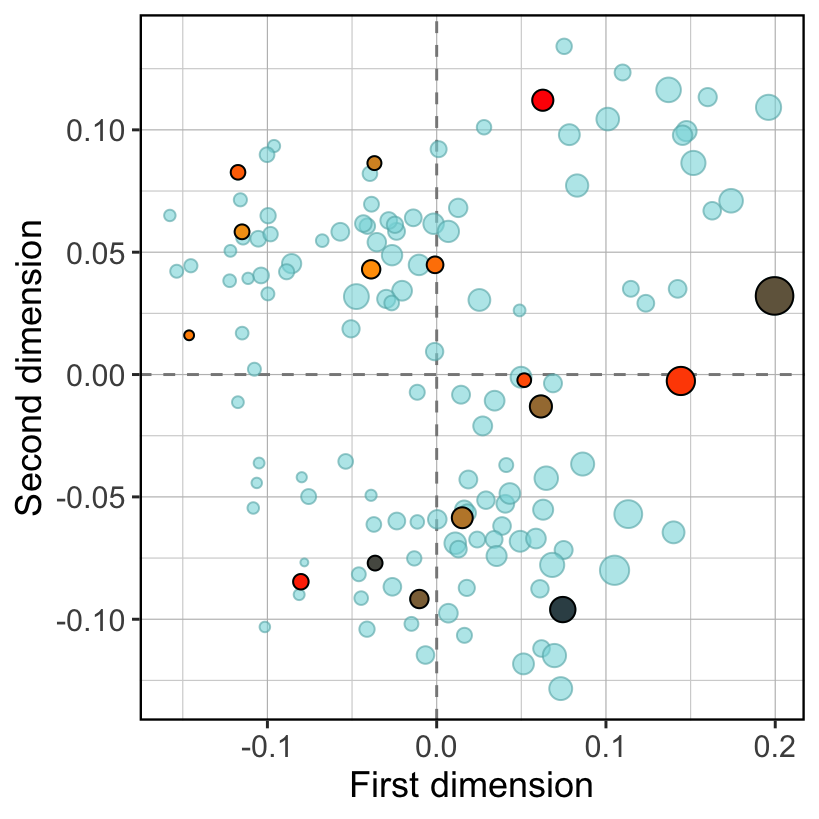

In [11]:
%%R -i df_volpk -w 4.1 -h 4.1 --units in -r 200

# source('../../R_scripts/plot_cMDS.R')

plot_cMDS(df_volpk)

## Swarplot with the AUC-ROC values per conformation
- The following plot show the distribution of the protein conformations regarding its AUC-ROC value computed from their individual docking results.

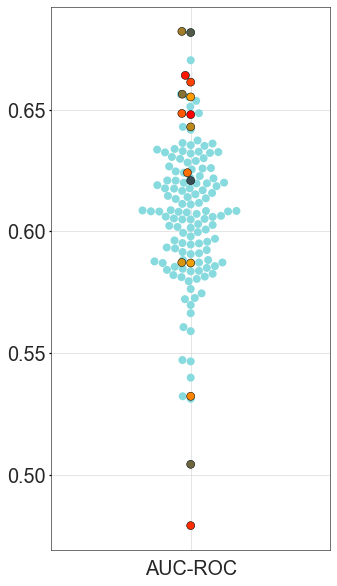

In [12]:
import matplotlib
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap

# Define the colormap
cmap = LinearSegmentedColormap.from_list(
    name ='test', 
    colors = ["red", "orange", "#374E55"],
    N = 16
)
matplotlib.cm.register_cmap("mycolormap", cmap)
sns.set(font_scale = 1.8, style = 'whitegrid')

# Filter the 
df_ = df_prot.copy()
# Get the top 16
df_['top_mask'] = [2 if i <= 16 else 
                   1 for i in df_['rfe_ranking']]
df_ = df_[['AUC-ROC', 'top_mask', 'rfe_ranking']]\
                    .melt(id_vars=('top_mask', 
                                   'rfe_ranking'))

fig, ax = plt.subplots(figsize=(5, 10))
# Blue dots (all conformations)
np.random.seed(2)
sns.swarmplot(y = 'value', 
              x = 'variable', 
              data = df_, 
              size = 8,
              ax = ax,
              color = '#87DADE')
# Plot the top RFE 16 conformations
df_top = df_.query('top_mask == 2') 
np.random.seed(2)
sns.swarmplot(y = 'value', 
              x = 'variable', 
              data = df_top, 
              size = 8,
              ax  = ax,
              hue ='rfe_ranking',
              edgecolor = 'black', 
              linewidth = 0.5,
              palette = 'mycolormap')
# Axis and labels
ax.set_yticks(np.arange(0.5, 0.70, .05))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
ax.yaxis.tick_left()
ax.get_legend().remove()
ax.tick_params(length = 2, color = 'black', axis = 'y')
ax.grid(True, linewidth = 0.5)
ax.set(xlabel = '', ylabel = '')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.55)
    ax.spines[axis].set_edgecolor('black')
plt.show()

## MDS using Secondary structure - Pisani (2016) residues.
- The following projection was computed from the pairwise RMSD matrix of the C$\alpha$ of the residues defined by Pisani (2016).

In [13]:
df_secRMSD = df_prot[['rfe_ranking', 'secres_x', 'secres_y', 'volume']]
df_secRMSD = df_secRMSD.rename({'secres_x': 'x', 'secres_y': 'y'}, axis = 1)

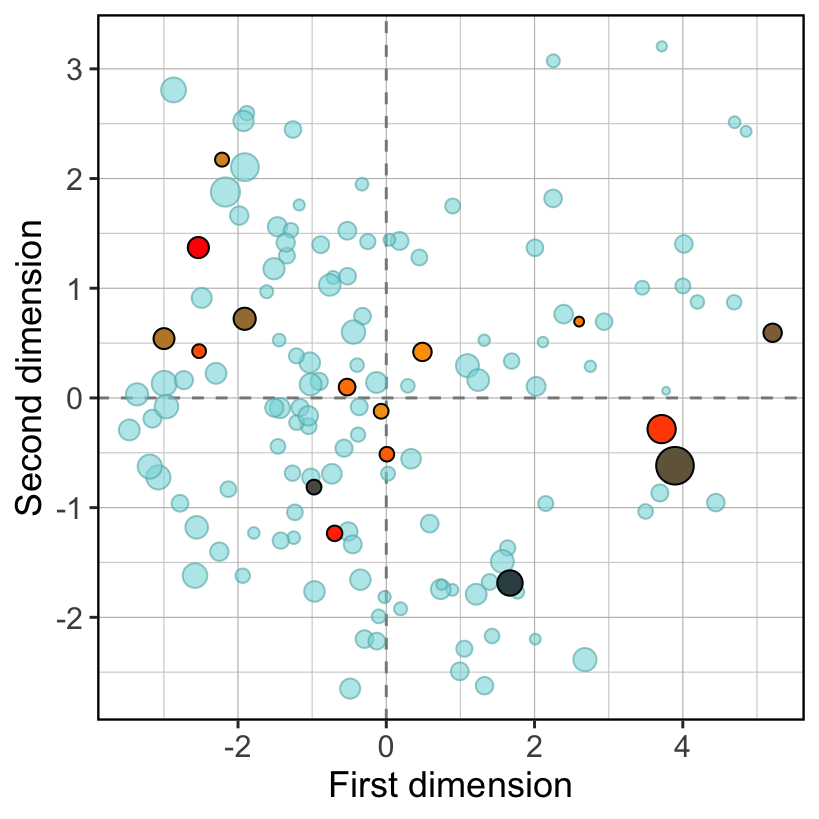

In [14]:
%%R -i df_secRMSD -w 4.1 -h 4.1 --units in -r 200

plot_cMDS(df_secRMSD)

## MDS using pocket residues

In [15]:
df_pkRMSD = df_prot[['rfe_ranking', 'pkt_x', 'pkt_y', 'volume']]
df_pkRMSD = df_pkRMSD.rename({'pkt_x': 'x', 'pkt_y': 'y'}, axis = 1)

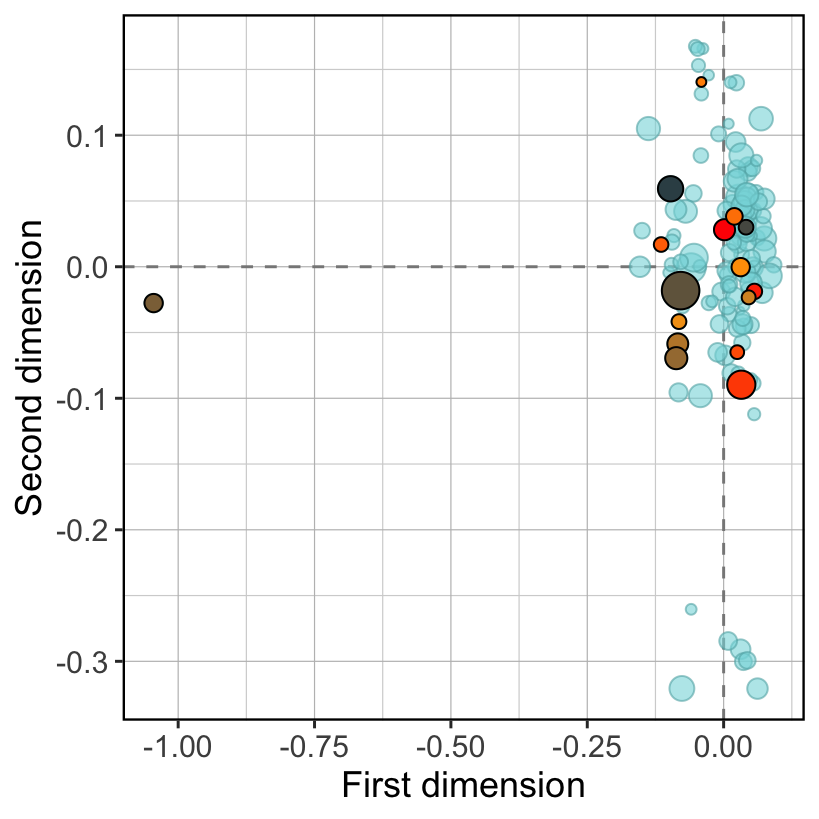

In [16]:
%%R -i df_pkRMSD -w 4.1 -h 4.1 --units in -r 200

plot_cMDS(df_pkRMSD)